In [1]:
import os
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant,CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.optimizers import LMSolver,LMProblem
import jax
from jsindy.optim.solvers.lm_solver import CholeskyLM, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import AlternatingActiveSolve
from jsindy.trajectory_model import TrajectoryModel
from jax.scipy.linalg import block_diag
import jax.numpy as jnp
from jsindy.util import full_data_initialize
from dataclasses import dataclass

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from jsindy.kernels import ConstantKernel,ScalarMaternKernel
exp_data = LorenzExp

## Notes on problem tweaks:
1. Keeping the problem roughly fixed in terms of collocation, etc.

2. Decreasing nugget in the RKHS interpolant helps a bit. 

## Notes on optimization tweaks
1. Switched to use chol reparametrization

2. Added 1 step of iterative refinement in LM algorithm steps

3. Added stopping conditions based on stagnation

In [2]:
class TestSolver():
    def __init__(
            self, 
            beta_reg = 1.,
            colloc_weight_scale = 100.,
            fixed_colloc_weight = None,
            solver_settings =  LMSettings(),
        ):
        self.solver_settings = solver_settings
        self.beta_reg = beta_reg
        self.colloc_weight_scale = colloc_weight_scale
        self.fixed_colloc_weight = fixed_colloc_weight

    def run(self, model, params):
        params["data_weight"] = 1/(params["sigma2_est"]+0.001)
        if self.fixed_colloc_weight is None:
            params["colloc_weight"] = self.colloc_weight_scale * params["data_weight"]
        else:
            params["colloc_weight"] = self.fixed_colloc_weight
        print(params)

        z0,theta0 = full_data_initialize(
            model.t,
            model.x,
            model.traj_model,
            model.dynamics_model,
            sigma2_est=params["sigma2_est"]+0.01
            )
        z_theta_init = jnp.hstack([z0,theta0.flatten()])

        def resid_func(z_theta):
            z = z_theta[:model.traj_model.tot_params]
            theta = z_theta[model.traj_model.tot_params:].reshape(
                model.dynamics_model.param_shape
            )
            return model.residuals.residual(
                z,
                theta,
                params["data_weight"], 
                params["colloc_weight"]
            )

        jac_func = jax.jacrev(resid_func)
        damping_matrix = block_diag(
            model.traj_model.regmat,
            model.dynamics_model.regmat
        )

        lm_prob = LMProblem(resid_func, jac_func, damping_matrix)
        if self.solver_settings.show_progress:
            print("Warm Start")
        z_theta, lm_opt_results = CholeskyLM(
            z_theta_init, 
            lm_prob,
            self.beta_reg,
            self.solver_settings
        )
        z = z_theta[:model.traj_model.tot_params]
        theta = z_theta[model.traj_model.tot_params:].reshape(
            model.dynamics_model.param_shape
        )
        return z, theta, lm_opt_results, params


In [3]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = 8.
dt = 0.12
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)
kernel = (
        ConstantKernel(variance = 5.)
        +ScalarMaternKernel(p = 5,variance = 10.)
    )   
trajectory_model = CholDataAdaptedRKHSInterpolant(kernel = kernel)#,nugget = 1e-8)
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 2000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-14,
    init_alpha = 5.,
    max_line_search_iterations=100,
)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=TestSolver(beta_reg=0.001,
                        solver_settings=optsettings,
                        fixed_colloc_weight=250.),
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(8.65377059, dtype=float64), 'data_weight': Array(0.11554321, dtype=float64), 'colloc_weight': 250.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 2.733e+07, gradnorm = 7.062e+07, alpha = 5.0, improvement_ratio = 0.766
Iteration 1, loss = 1.392e+07, gradnorm = 5.989e+08, alpha = 5.0, improvement_ratio = 0.4907
Iteration 2, loss = 3.869e+06, gradnorm = 4.518e+08, alpha = 5.0, improvement_ratio = 0.722
Iteration 3, loss = 3.454e+06, gradnorm = 4.795e+08, alpha = 45.56, improvement_ratio = 0.1073
Iteration 4, loss = 4.537e+04, gradnorm = 3.598e+08, alpha = 37.97, improvement_ratio = 0.9869
Iteration 5, loss = 1.018e+03, gradnorm = 3.207e+07, alpha = 31.64, improvement_ratio = 0.9811
Iteration 200, loss = 98.8, gradnorm = 1.286e+04, alpha = 0.7164, improvement_ratio = 0.7848
Iteration 400, loss = 93.66, gradnorm = 1.821e+03, alpha = 0.0558, improvement_ratio = 0.7427
Iteration 519, loss = 93.56, gradnorm = 0.03237, alpha = 83.33, improvement_ratio = 1.274e+04


1.0689502165867089


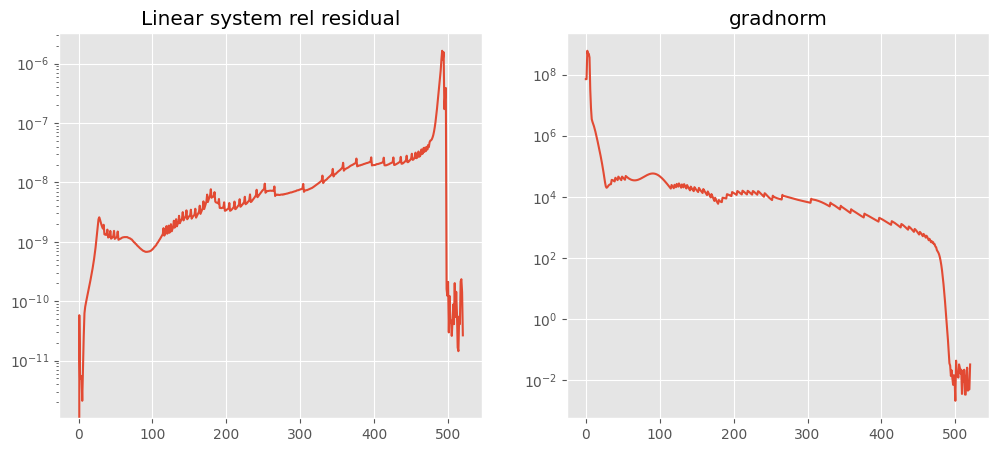

In [6]:
opt = model.opt_result
metrics = {}
metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)
metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
print(metrics['data_mets']['normalized_mse'])
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(opt.linear_system_rel_residual)
plt.title("Linear system rel residual")
plt.yscale('log')
plt.subplot(1,2,2)
plt.title("gradnorm")
plt.plot(opt.gradnorm)
plt.yscale('log')
plt.show()

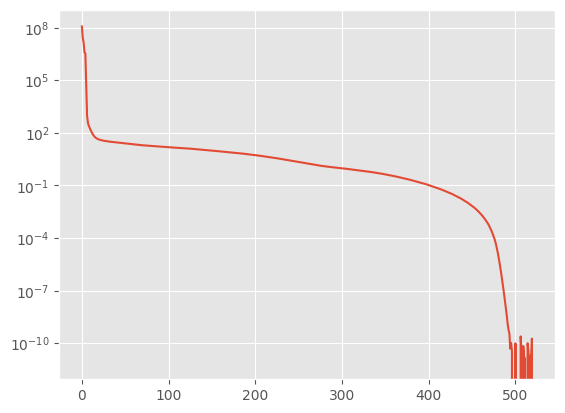

In [7]:
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')

In [8]:
metrics = {}
metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)
metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics

{'coeff_mets': {'precision': 0.23333333333333334,
  'recall': 1.0,
  'f1': 0.3783783783783784,
  'coeff_rel_l2': 1.4578665820598962,
  'coeff_rmse': 8.392176662493561,
  'coeff_mae': 4.506406084823633},
 'data_mets': {'mse': Array(4158.58505104, dtype=float64),
  'rmse': np.float64(64.4870921273584),
  'mae': np.float64(27.423304726422217),
  'max_abs_error': np.float64(659.4351677327655),
  'normalized_mse': Array(1.06895022, dtype=float64),
  'relative_l2_error': np.float64(1.0337356522517906)}}

In [9]:
model.print()

(x)' = 0.063 1 + 12.940 x + -2.523 y + -1.729 z + -0.994 x^2 + 0.644 x y + -0.695 x z + 0.064 y^2 + 0.369 y z + 0.086 z^2
(y)' = 28.948 1 + 18.687 x + 4.101 y + -4.117 z + -3.925 x^2 + 5.271 x y + -0.509 x z + -1.781 y^2 + -0.324 y z + 0.163 z^2
(z)' = 18.994 1 + -2.980 x + 2.006 y + -4.146 z + -2.802 x^2 + 5.740 x y + 0.276 x z + -2.006 y^2 + -0.311 y z + 0.059 z^2


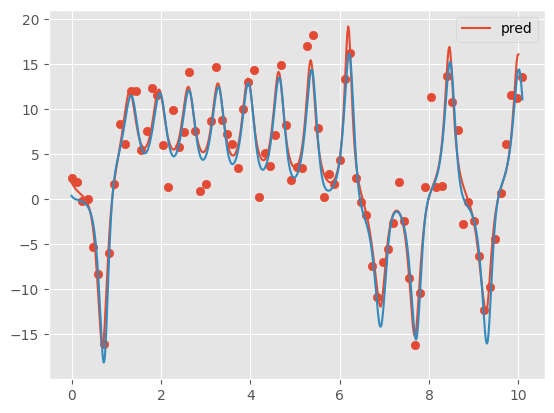

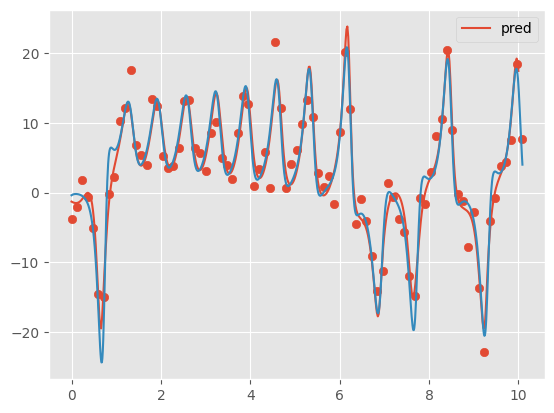

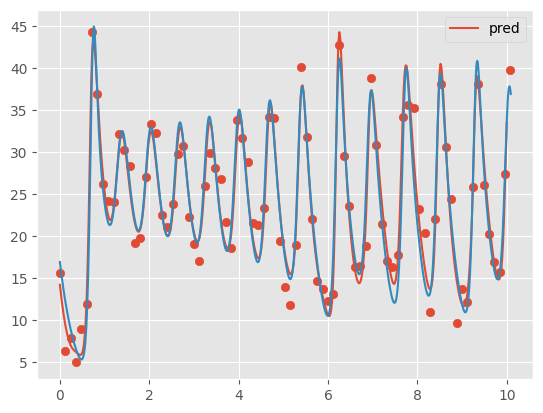

In [10]:
t_grid = jnp.linspace(0,10,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i])
    plt.legend()
    plt.show()

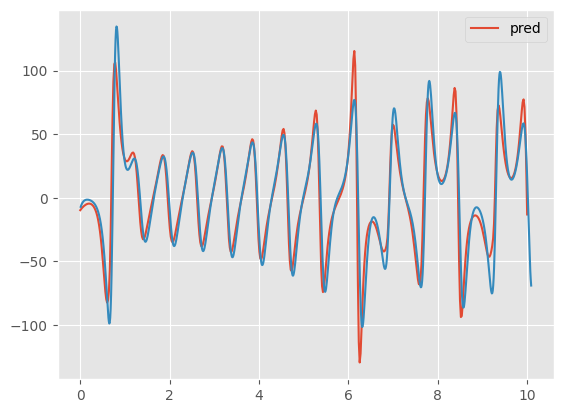

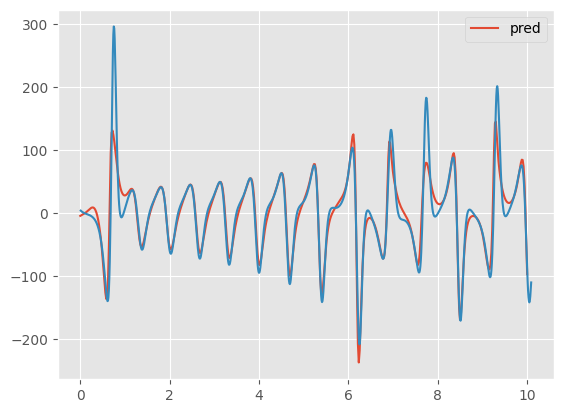

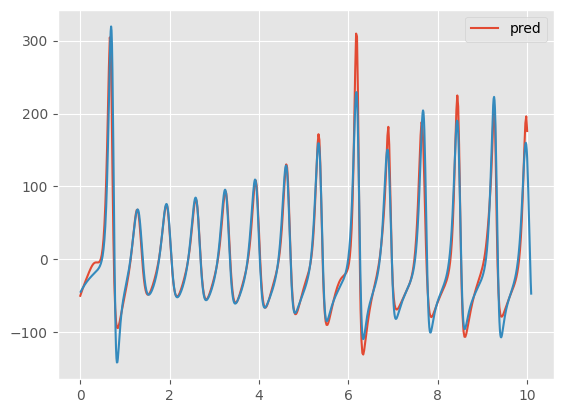

In [11]:
t_grid = jnp.linspace(0,10,500)
xdot_pred = model.traj_model.derivative(t_grid,model.z)

h = expdata.t_true[1]-expdata.t_true[0]
for i in range(3):
    plt.plot(t_grid,xdot_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true[1:],jnp.diff(expdata.x_true[:,i])/h)
    plt.legend()
    plt.show()

In [12]:
t_grid = jnp.linspace(0,10,2000)

xdot_pred = model.traj_model.derivative(t_grid,model.z)
x_pred = model.predict_state(t_grid)
A = dynamics_model.feature_map(x_pred)

I = jnp.eye(A.shape[1])
refit_theta = jnp.linalg.solve(A.T@A + 0.1*I ,A.T@xdot_pred)

from pysindy import STLSQ,SR3,EnsembleOptimizer
stlsq = STLSQ(threshold = 0.25,alpha =0.01,unbias = True)
optimizer = stlsq#EnsembleOptimizer(stlsq,library_ensemble=True,bagging = True,n_subset = 100)
optimizer.fit(A,xdot_pred)
refit_theta = jnp.array(optimizer.coef_).T

model.print(refit_theta)

(x)' = 11.154 x + -1.028 y + -0.660 x z + 0.316 y z
(y)' = -23.017 1 + 13.085 x + 6.620 y + 1.867 z + -1.990 x^2 + 2.624 x y + -0.478 x z + -0.873 y^2 + -0.277 y z
(z)' = -5.000 x + 2.913 y + -1.971 z + -2.105 x^2 + 4.787 x y + 0.287 x z + -1.678 y^2 + -0.294 y z


In [13]:
jnp.mean((dynamics_model.predict(expdata.x_test,refit_theta) - expdata.x_dot_test)**2)/jnp.var(expdata.x_dot_test)

Array(0.42365765, dtype=float64)

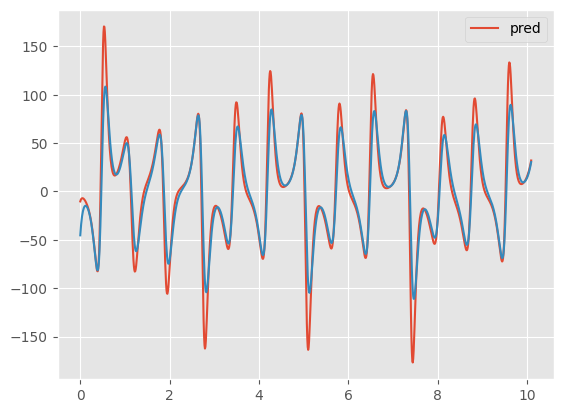

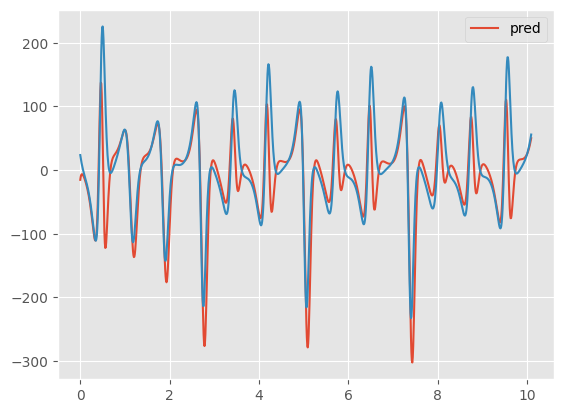

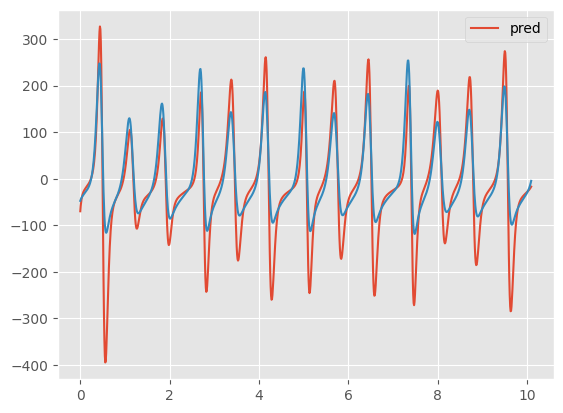

In [14]:
test_pred = dynamics_model.predict(expdata.x_test,refit_theta)
for i in range(3):
    plt.plot(expdata.t_true,test_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_dot_test[:,i])
    plt.legend()
    plt.show()